# 3.3. Find Balance of Friction with Static Analysis



In [1]:
%config InlineBackend.figure_format = "svg"
import numpy as np
from matplotlib import pyplot as plt
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


## 3.3.1. 






In [2]:
def get_mesh(n_r, n_t):
    OffbyOne = lambda n : (np.arange(n) + 0.5) / n

    r = OffbyOne(n_r)
    t = OffbyOne(n_t) * 2 * np.pi

    dt = t[1] - t[0]
    r_node = np.linspace(0., 1., n_r+1)
    Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
    ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

    r_, t_ = np.meshgrid(r, t)
    ratio, t_ = np.meshgrid(ratio_dt, t)

    r_mesh = r_.reshape(-1)
    t_mesh = t_.reshape(-1)
    ratio_mesh = ratio.reshape(-1)
    x_mesh = r_mesh * np.cos(t_mesh)
    y_mesh = r_mesh * np.sin(t_mesh)
    return r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh


In [3]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10


In [4]:
xvw_ball = np.array([7.49210016e-01,  1.86156815e+01,  9.44929460e+00,
                     7.47967885e+01, -4.44060876e+02,  8.74832706e+02,
                    -3.34346167e+02, -1.05114502e+02, -2.10343819e+01])

vFmTI = np.array([ 7.47967885e+01, -4.44060876e+02,  8.74832706e+02,
                  -3.22543376e-01, -4.11165677e+04, -2.08616809e+04,
                   8.00162641e+01,  9.20168223e+02, -4.98204570e+03])


In [5]:
n_r = 36
n_t = 12

r_mesh, t_mesh, ratio_mesh, x_mesh, y_mesh = get_mesh(n_r, n_t)

x_square = np.square(x_mesh)
y_square = np.square(y_mesh)


In [6]:
r_meas = np.sqrt(np.square(xvw_ball[1:3]).sum())
v_meas = np.sqrt(np.square(xvw_ball[4:6]).sum())
w_meas = v_meas / r_meas
a_theor = np.square(v_meas) / r_meas * -xvw_ball[1:3] / r_meas

a_theor

array([-41112.12013441, -20868.45624108])

In [7]:
vFmTI[4:6]


array([-41116.5677, -20861.6809])

In [8]:
L = Ball_I * xvw_ball[6:9]
omega = np.array([w_meas, 0.0, 0.0])

np.cross(omega, L) / Ball_I


array([    0.        ,   988.49669503, -4939.78564814])

In [9]:
vFmTI[6:9]


array([   80.0162641,   920.168223 , -4982.0457   ])

In [10]:
r_ball = xvw_ball[0:3].copy()
r_ball[0] = 0.0
v_ball = xvw_ball[3:6]

axis = np.cross(r_ball, v_ball)
axis = axis / np.linalg.norm(axis)

r_aprx = SP2.nd**2 / SP2.r
v_aprx = np.linalg.norm(v_ball)

w_axis = axis * v_aprx / r_aprx
np.cross(w_axis, L) / Ball_I


array([ -367.81977555,  2044.9333354 , -4372.50866266])

In [11]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def static_spiral(xvw_ball, v_pure, v_guide, w_pure, mode):
    
    th = 0.0
    eta_ball = np.array([th, xvw_ball[0], xvw_ball[1]])
    x_ball   = SP12[1].to_xyz(eta_ball)
        
    if mode==1:
        v_ball = (xvw_ball[2:3] + v_pure) * v_guide
        w_ball = xvw_ball[3:6] + w_pure
    
    Zeros = np.zeros(3)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    parabola  = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    muF_    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        
        if mode==1:        
            v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                
                if mode==0:        
                    F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, 0, dx[iSP,i])
                    F_[iSP,i,:]   = - F_norm[iSP,i] * np.array([0, cos_sin[iSP,i,0], cos_sin[iSP,i,1]])
                    if (iSP==0) and (w12[0,0]>w12[1,0]):
                        muF_[iSP,i,:] = 0.5 * mu * F_norm[iSP,i] * np.array([0,-cos_sin[iSP,i,1], cos_sin[iSP,i,0]])
                    else:
                        muF_[iSP,i,:] = 0.5 * mu * F_norm[iSP,i] * np.array([0, cos_sin[iSP,i,1],-cos_sin[iSP,i,0]])
                
                if mode==1:        
                    v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                    F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])                    
                    F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]
                
                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                
                if mode==1:
                    for j in range(2):
                        parabola[iSP,i,j] = TB.Parabola(Ball_r_inv, SP_r_inv[iSP,i,j], dx[iSP,i])

                    p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(parabola[iSP,i,1] * np.square(a_[iSP,i]) * x_square - parabola[iSP,i,0] * np.square(b_[iSP,i]) * y_square, -exyz[iSP,i,:])
                    F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                    SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                    BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                    dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                    v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                    muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                    muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                    
    if mode==0:
        return ((F_ + muF_).sum(0).sum(0))[1:]
                
    if mode==1:
        Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
        TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
        Fm_cent = np.array([0.0, -41112.12013441, -20868.45624108])
        TI_cent = np.array([0.0,    988.49669503, -4939.78564814])

        return np.concatenate([Fm_ball - Fm_cent, TI_ball - TI_cent])
    
    return 0


In [12]:
from scipy.optimize import fsolve

eta_init = np.array([-0.0, -0.])
eta0 = fsolve(static_spiral, eta_init, args=(0,0,0,0))

print(eta_init)
print(eta0)
print(static_spiral(eta0, 0, 0, 0, 0))


[-0. -0.]
[-0.00163693 -0.00112587]
[1.01287867e-10 5.94440053e-11]


| Shaft \ Nut | 0     | 1     | 2   |
|-------------|-------|-------|-----|
| 0           | Nut   | Nut   | Nut |
| 1           | Shaft | Nut   | Nut |
| 2           | Shaft | Shaft | Nut |

In [13]:
def get_vw_pure(eta0):
    
    th = 0.0
    eta_ball = np.array([th, eta0[0], eta0[1]])
    x_ball   = SP12[1].to_xyz(eta_ball)
        
    Zeros = np.zeros(3)
    
    dx      = np.zeros([2, 2])
    cos_sin   = np.zeros([2, 2, 2])
    
    exyz    = np.zeros([2, 2, 3])
    peak    = exyz.copy()
    SP_v_   = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])    
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        
        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
            SP_v_[iSP,i]  = TB.surface_velocity(Zeros, peak[iSP,i,:], v12[iSP], w12[iSP])
            
    contact_point = (dx > 0).sum(1)
    
    if contact_point[0] > contact_point[1]:
        SPguide = SP1
        v_guide = b_dir[0]
    
    else:
        SPguide = SP2
        v_guide = b_dir[1]

    dx_reshape = dx.reshape(-1)
    dx_order = np.argsort(dx_reshape)
    
    v_surface = np.dot(SP_v_, v_guide)
    v_top2    = v_surface.reshape(-1)[dx_order[-2:]]    
    v_pure    = v_top2.mean()
    
    x_top2  = peak.reshape(-1,3)[dx_order[-2:]]
    x_dist  = x_top2[1] - x_top2[0]
    r_round = np.linalg.norm(x_dist) * 0.5
    w_pure0 = v_pure / r_round
    w_axis  = np.cross(x_dist, v_guide)
    w_axis  = w_axis / np.linalg.norm(w_axis)
    
    w_pure  = w_pure0 * w_axis
    
    return v_pure, v_guide, w_pure


In [14]:
v_pure, v_guide, w_pure = get_vw_pure(eta0)
print(v_pure, v_guide, w_pure)


981.0706591338984 [0.07602126 0.00174028 0.99710468] [-216.26562137 -220.20889471   16.87286201]


In [15]:
xvw_ball = np.zeros(6)
xvw_ball[:2] = eta0
print(static_spiral(xvw_ball, v_pure, v_guide, w_pure, 1))


[   14829.30462232 -1151505.03372181 -1159969.86709142  -503254.20989865
  -383621.28166215  3338516.78232955]


In [16]:
xvw_ball0 = fsolve(static_spiral, xvw_ball, args=(v_pure, v_guide, w_pure, 1))
xvw_ball0


array([-1.60396515e-03, -1.13528897e-03,  2.83771390e+00, -1.16384981e+02,
        1.15326087e+02,  1.19929880e+01])

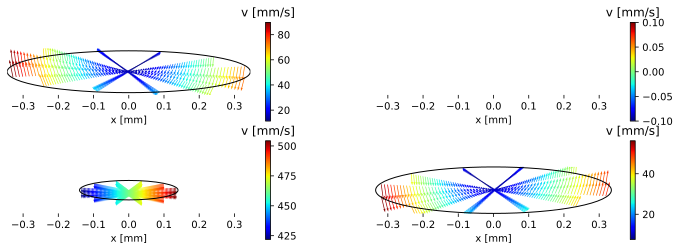

In [17]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    parabola  = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                for j in range(2):
                    parabola[iSP,i,j] = TB.Parabola(Ball_r_inv, SP_r_inv[iSP,i,j], dx[iSP,i])
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(parabola[iSP,i,1] * np.square(a_[iSP,i]) * x_square - parabola[iSP,i,0] * np.square(b_[iSP,i]) * y_square, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    if mode == 4:
        return p_mesh
    
    if mode == 5:
        return muF, muT
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])

from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

def plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, dv_unit):
    # Defining subplots
    fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

    # Creating plot
    a_max = a_.max()
    b_max = b_.max()

    for iSP in range(2):
        for i in range(2):
            a_mesh00 = a_[iSP,i] * x_mesh
            b_mesh00 = b_[iSP,i] * y_mesh

            dvx00 = dv[iSP,i,:,:].dot(a_dir[iSP,i,:])
            dvy00 = dv[iSP,i,:,:].dot(b_dir[iSP,:])

            dv_norm = np.sqrt(np.square(dvx00) + np.square(dvy00))

            ellipse = Ellipse(xy=(0.0, 0.0), width=2*a_[iSP,i], height=2*b_[iSP,i], edgecolor='k', fc='None')
            quiver = ax[iSP, i].quiver(a_mesh00, b_mesh00, dvx00, dvy00, dv_norm, cmap='jet')
            ax[iSP, i].add_patch(ellipse)
            ax[iSP, i].set_aspect('equal')
            ax[iSP, i].axis([-a_max, a_max, -b_max, b_max])
            ax[iSP, i].spines['right'].set_visible(False)
            ax[iSP, i].spines['top'].set_visible(False)
            ax[iSP, i].spines['left'].set_visible(False)
            ax[iSP, i].spines['bottom'].set_visible(False)
            ax[iSP, i].yaxis.set_ticks([])
            ax[iSP, i].set_xlabel('x [mm]')
            colorbar = fig.colorbar(quiver, ax=ax[iSP, i])
            colorbar.ax.set_title(dv_unit)
            
    return fig, ax

th = 0.0
eta_ball = np.array([th, xvw_ball0[0], xvw_ball0[1]])
x_ball   = SP12[1].to_xyz(eta_ball)
v_ball   = (xvw_ball0[2:3] + v_pure) * v_guide
w_ball   = xvw_ball0[3:6] + w_pure

xvw_ball_hoge = np.concatenate([x_ball, v_ball, w_ball]) 

a_, b_, a_dir, b_dir, dv = vFmTI_ball(xvw_ball_hoge, 0, 1)
fig, ax = plot_Vector_field(a_, b_, x_mesh, y_mesh, a_dir, b_dir, dv, 'v [mm/s]')


In [18]:
xvw_ball0 = fsolve(static_spiral, xvw_ball*0, args=(v_pure, v_guide, w_pure, 1))
xvw_ball0


array([-1.60396515e-03, -1.13528897e-03,  2.83771392e+00, -1.16384981e+02,
        1.15326087e+02,  1.19929880e+01])

In [19]:
print(v_pure, v_guide, w_pure)

981.0706591338984 [0.07602126 0.00174028 0.99710468] [-216.26562137 -220.20889471   16.87286201]
